In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
x = np.linspace(0, 50, 501)

In [4]:
y = np.sin(x)

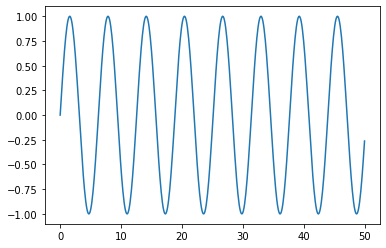

In [6]:
plt.plot(x, y)

In [7]:
df = pd.DataFrame(y, index = x, columns=['Sine'])
df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


In [8]:
len(df)

501

In [9]:
test_percent = 0.2

In [12]:
501 * (20/100)

100.2

In [11]:
train_df = df.iloc[:400]
test_df = df.iloc[400:]

In [13]:
train_df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


In [14]:
test_df.head()

,Sine
40.0,0.745113
40.1,0.674808
40.2,0.597760
40.3,0.514740
40.4,0.426577


In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [18]:
scaler.fit(train_df)

MinMaxScaler()

In [20]:
train = scaler.transform(train_df)
test = scaler.transform(test_df)

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
generator = TimeseriesGenerator(train, train, length = 2, batch_size = 1)

In [24]:
generator[0]

(array([[[0.49999912],
         [0.54991622]]]),
 array([[0.59933458]]))

In [25]:
generator = TimeseriesGenerator(train, train, length = 50, batch_size = 1)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [27]:
length = 50
n_features = 1

In [28]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(50, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

2022-04-30 17:18:52.511103: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(generator, epochs = 5)

Epoch 1/5
350/350 [==============================] - 6s 11ms/step - loss: 0.0095
Epoch 2/5
350/350 [==============================] - 4s 10ms/step - loss: 3.7362e-05
Epoch 3/5
350/350 [==============================] - 4s 11ms/step - loss: 3.8001e-04
Epoch 4/5
350/350 [==============================] - 4s 11ms/step - loss: 6.6447e-05
Epoch 5/5
350/350 [==============================] - 4s 10ms/step - loss: 2.2566e-05


In [31]:
loss_df = pd.DataFrame(model.history.history)

In [32]:
loss_df.head()

,loss
0,0.009467
1,0.000037
2,0.000380
3,0.000066
4,0.000023


<AxesSubplot:>

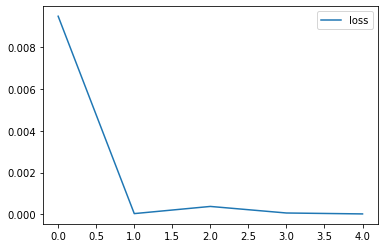

In [33]:
loss_df.plot()